Experimento preliminar: comparar utilizar comunidades originales vs modificadas.

In [1]:
import numpy as np
import seaborn, math, os
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from copy import deepcopy

C:\Anaconda\envs\py35\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [167]:
%run modelo.py
%run medidas_biodiversidad.py

In [3]:
datos_iteraciones = []
with open('iteraciones.txt', 'r') as file:
    rows = file.readlines()
    for row in rows:
        datos_iteraciones.append([row[:20], int(row[-2])])

In [4]:
all_condiciones_iniciales = [np.loadtxt("./comunidades/" + file[0][:20] + "-c.txt") for file in datos_iteraciones]
all_tasas_reproduccion = [np.loadtxt("./comunidades/" + file[0][:20] + "-v.txt") for file in datos_iteraciones]
all_matriz_interacciones = [np.loadtxt("./comunidades/" + file[0][:20] + '-m.txt') for file in datos_iteraciones]
all_iteraciones = [file[1] for file in datos_iteraciones]

In [166]:
def modificar_matriz(m):
    for i in range(10):
        m[i][i] *= 15
    return m

def modificar_tasas(tasa):
    tasa[tasa > 0] = tasa[tasa > 0] * 20
    return tasa

def modificar_condiciones0(c0):
    c0 = c0 * 10
    return c0

In [6]:
# Escoger 40 comunidades de cada tipo: oscilante y punto fijo
os = []
eq = []
for i, comunidad in enumerate(datos_iteraciones):
    if comunidad[0][-2:] == 'os' and comunidad[1] != 0:
        os.append(i)
    elif comunidad[0][-2:] == 'eq' and comunidad[1] != 0:
        eq.append(i)    

In [121]:
comunidades = os[2:3] + eq[2:3]

## Experimento: comunidades originales
Parámetros

In [122]:
paisajes = np.load("../proyectof/paisajes_h2.npy")

Dispersion = {"b": 0.3,
              "m": 1,
              "i": 1}

Mortalidad = {"b": 0,
              "m": 0.6,
              "i": 0.9}
t_total = 40

In [123]:
for c in comunidades:
    res = [None] * len(paisajes)
    for p in range(len(paisajes)):
        res[p] = matriz_agroecologica(paisajes[p].tolist(),
                                      all_matriz_interacciones[c], 
                                      all_tasas_reproduccion[c], 
                                      all_condiciones_iniciales[c],
                                      t_total, 
                                      Dispersion,
                                      Mortalidad,
                                      all_iteraciones[c])
        #res[p] = res[p][-all_iteraciones[c]:] guardar todo
    res = np.array(res)
    np.save("./datos/exp_prelim1_c{:03d}".format(c), res)

## Experimento: comunidades modificadas

In [168]:
paisajes = np.load("../proyectof/paisajes_h2.npy")

Dispersion = {"b": 0.3,
              "m": 1,
              "i": 1}

Mortalidad = {"b": 0,
              "m": 0.6,
              "i": 0.9}
t_total = 40

matriz_interacciones2 = deepcopy(all_matriz_interacciones)
matriz_interacciones2 = [modificar_matriz(m) for m in matriz_interacciones2]

condiciones_iniciales2 = deepcopy(all_condiciones_iniciales)
condiciones_iniciales2 = [modificar_condiciones0(m) for m in condiciones_iniciales2]

tasas_reproduccion2 = deepcopy(all_tasas_reproduccion)
tasas_reproduccion2 = [modificar_tasas(t) for t in tasas_reproduccion2]

pasos_mm = 2

In [169]:
for c in comunidades:
    res = [None] * len(paisajes)
    for p in range(len(paisajes)):
        res[p] = matriz_agroecologica(paisajes[p].tolist(),
                                      matriz_interacciones2[c], 
                                      tasas_reproduccion2[c], 
                                      condiciones_iniciales2[c],
                                      t_total, 
                                      Dispersion,
                                      Mortalidad,
                                      pasos_mm)
        #res[p] = res[p][-all_iteraciones[c]:] guardar todo
    res = np.array(res)
    np.save("./datos/exp_prelim3_c{:03d}".format(c), res)

## Análisis de datos

In [236]:
poblacion = np.load('./datos/exp_prelim3_c064.npy')
poblacion = poblacion[-1]
paisaje = paisajes[0].tolist()

biomasa_min = 5

# Biomasa paisaje
biomasa = [None] * len(poblacion)
riqueza = [None] * len(poblacion)

for i in range(len(poblacion)):
    biomasa[i] = riqueza_paisaje(poblacion, i, biomasa_min)[0] 
    riqueza[i] = riqueza_paisaje(poblacion, i, biomasa_min)[1]

riqueza_milpa = [None] * len(poblacion)
biomasa_milpa = [None] * len(poblacion)

for i in range(len(poblacion)):
    riqueza_milpa[i] = riqueza_agricola(poblacion, paisaje, i, biomasa_min)[1]   
    biomasa_milpa[i] = riqueza_agricola(poblacion, paisaje, i, biomasa_min)[0]   

<IPython.core.display.Javascript object>


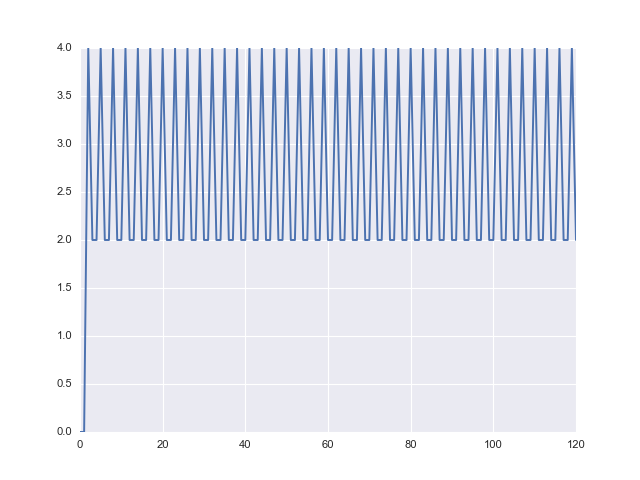

In [237]:
%matplotlib notebook
fig = plt.figure()
plt.plot(range(len(riqueza_milpa)), riqueza_milpa)
#plt.xlim(0, 100)

<IPython.core.display.Javascript object>


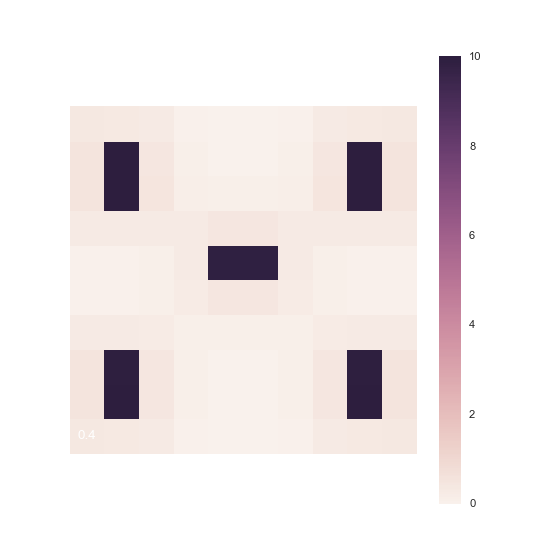

In [87]:
biomasa_celda = medidas_por_celda(poblacion, -1, biomasa_min)[0]
riqueza_celda = medidas_por_celda(poblacion, -1, biomasa_min)[1]

fig = plt.figure(figsize=(7,7))
seaborn.heatmap(biomasa_celda, yticklabels=False,
               xticklabels=False, vmin = 0.0, annot=True, fmt=".1f", square=True) 

#seaborn.heatmap(poblacion[-2, :, :, 1], yticklabels=False,
#               xticklabels=False, vmin = 0.0, annot=True, fmt=".1f", square=True) 
plt.show() 

In [238]:
print(all_matriz_interacciones[71], '\n tasas', 
      all_tasas_reproduccion[71], '\n c0', all_condiciones_iniciales[71])

[[-0.13209503  0.          0.          0.          1.49521416  1.52608714
   0.          0.          0.          1.66703598]
 [ 0.         -0.19037627  1.07471353 -0.07279291 -0.05053817  0.
  -0.13251349 -0.09278112  0.          0.        ]
 [ 0.         -0.0908119  -0.11764098  0.          0.          0.
  -0.12768799 -0.16586701  0.          0.        ]
 [ 0.          1.95383614  0.         -0.17119497 -0.1274973   0.
  -0.01757984 -0.14316515  0.03852533  0.        ]
 [-0.1850161   1.2447211   0.          1.77580454 -0.13294429 -0.04953677
  -0.05430419 -0.14268237  1.48377961  0.        ]
 [-0.16375819  0.          0.          0.          1.37269278 -0.12307916
   0.          0.          0.          1.28734844]
 [ 0.          1.67038085  0.76632074  0.25509129  0.42776016  0.
  -0.07132569  0.          1.71310416  1.40602576]
 [ 0.          0.73097573  0.70783559  1.40565244  0.17813263  0.          0.
  -0.06466112  0.09595973  0.        ]
 [ 0.          0.          0.         -0

In [240]:
print(matriz_interacciones2[71], '\n tasas', 
      tasas_reproduccion2[71], '\n c0', condiciones_iniciales2[71])

[[-1.98142546  0.          0.          0.          1.49521416  1.52608714
   0.          0.          0.          1.66703598]
 [ 0.         -2.85564408  1.07471353 -0.07279291 -0.05053817  0.
  -0.13251349 -0.09278112  0.          0.        ]
 [ 0.         -0.0908119  -1.76461464  0.          0.          0.
  -0.12768799 -0.16586701  0.          0.        ]
 [ 0.          1.95383614  0.         -2.56792459 -0.1274973   0.
  -0.01757984 -0.14316515  0.03852533  0.        ]
 [-0.1850161   1.2447211   0.          1.77580454 -1.9941643  -0.04953677
  -0.05430419 -0.14268237  1.48377961  0.        ]
 [-0.16375819  0.          0.          0.          1.37269278 -1.84618747
   0.          0.          0.          1.28734844]
 [ 0.          1.67038085  0.76632074  0.25509129  0.42776016  0.
  -1.06988528  0.          1.71310416  1.40602576]
 [ 0.          0.73097573  0.70783559  1.40565244  0.17813263  0.          0.
  -0.96991681  0.09595973  0.        ]
 [ 0.          0.          0.         -0